In [1]:
from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
from IPython.core.display import display, HTML

from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import gc



# --- models ---
#from sklearn import preprocessing
from sklearn.model_selection import KFold,GroupKFold
import lightgbm as lgb
import xgboost as xgb
#import catboost as cb
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
import joblib
import pickle

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def memory_reduction(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'
          .format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
merged_train = pd.read_feather('../input/energy-feature-engineering-2/merged_train.feather')

In [4]:
siteid = 14

In [5]:
merged_train = merged_train[merged_train['site_id']==siteid]

In [6]:
merged_train.sort_values("timestamp")
merged_train.reset_index(drop=True)         

,index,building_id,meter,timestamp,meter_reading_log1p,weekend,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,IsHoliday,month_group,horizsolar,Sensible_Heat,relative_humidity
0,1673,1223,0,2016-01-01 00:00:00,4.392538,4,14,2,10.861726,4.4,1.333333,-2.8,0.0,1.0,1,0.0,0.040443,59.521717
1,1674,1223,1,2016-01-01 00:00:00,5.167274,4,14,2,10.861726,4.4,1.333333,-2.8,0.0,1.0,1,0.0,0.040443,59.521717
2,1675,1223,3,2016-01-01 00:00:00,6.081390,4,14,2,10.861726,4.4,1.333333,-2.8,0.0,1.0,1,0.0,0.040443,59.521717
3,1676,1224,0,2016-01-01 00:00:00,2.564949,4,14,2,10.063990,4.4,1.333333,-2.8,0.0,1.0,1,0.0,0.037473,59.521717
4,1677,1224,1,2016-01-01 00:00:00,5.147227,4,14,2,10.063990,4.4,1.333333,-2.8,0.0,1.0,1,0.0,0.037473,59.521717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2501501,19852066,1323,1,2016-12-31 23:00:00,0.000000,5,14,2,11.375971,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
2501502,19852067,1323,3,2016-12-31 23:00:00,7.555031,5,14,2,11.375971,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
2501503,19852068,1324,0,2016-12-31 23:00:00,2.708050,5,14,3,11.346741,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
2501504,19852069,1324,1,2016-12-31 23:00:00,0.000000,5,14,3,11.346741,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN


In [7]:
merged_train.columns

Index(['index', 'building_id', 'meter', 'timestamp', 'meter_reading_log1p',
       'weekend', 'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'IsHoliday',
       'month_group', 'horizsolar', 'Sensible_Heat', 'relative_humidity'],
      dtype='object')

In [8]:
merged_train["hour"] = merged_train["timestamp"].dt.hour #converting timestamp to hour

In [9]:
merged_train = merged_train.drop(['index',"timestamp"],axis=1)

In [10]:
merged_train = merged_train.drop(['month_group','Sensible_Heat', 'relative_humidity'],axis=1)

In [11]:
merged_train.columns

Index(['building_id', 'meter', 'meter_reading_log1p', 'weekend', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'IsHoliday', 'horizsolar',
       'hour'],
      dtype='object')

In [12]:
target = merged_train['meter_reading_log1p'].reset_index()
merged_train = merged_train.drop(['meter_reading_log1p'], axis=1).reset_index()

In [13]:
#.reset_index()


In [14]:
merged_train = merged_train.drop(['index'],axis = 1)
target = target.drop(['index'],axis = 1)

In [15]:
#https://www.kaggle.com/gunesevitan/ashrae-lightgbm-1-048-no-leak

cat_features = ["building_id", "site_id", "meter", "primary_use", "weekend",'IsHoliday']#, 'month_group'
params = {
    "objective": "regression","boosting": "gbdt","num_leaves": 31,"max_depth": 11,"learning_rate": 0.05,
    "feature_fraction": 0.9,"reg_lambda": 2,"metric": "rmse","n_estimators":5000
}

kf = GroupKFold(n_splits = 3)
models = []
i = 0
for train_index,valid_index in kf.split(merged_train,,groups = merged_train["month_group"]):
    xx_train = merged_train.loc[train_index]
    yy_train = target.loc[train_index]
    
    xx_valid = merged_train.loc[valid_index]
    yy_valid = target.loc[valid_index]
    
    d_training = lgb.Dataset(xx_train, label=yy_train,categorical_feature=cat_features, free_raw_data=False)
    d_valid = lgb.Dataset(xx_valid, label=yy_valid,categorical_feature=cat_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_valid], verbose_eval=25, early_stopping_rounds=100)
    filename = 'lgb_reg_site3'+ str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    i +=1
    models.append(model)
    del xx_train, yy_train, xx_valid, yy_valid, d_training, d_valid
    gc.collect()        

Training until validation scores don't improve for 100 rounds
[25]	training's rmse: 1.7198	valid_1's rmse: 1.78198
[50]	training's rmse: 1.55319	valid_1's rmse: 1.68791
[75]	training's rmse: 1.47874	valid_1's rmse: 1.64929
[100]	training's rmse: 1.4261	valid_1's rmse: 1.63256
[125]	training's rmse: 1.39048	valid_1's rmse: 1.62008
[150]	training's rmse: 1.36809	valid_1's rmse: 1.6104
[175]	training's rmse: 1.3505	valid_1's rmse: 1.6067
[200]	training's rmse: 1.33595	valid_1's rmse: 1.60286
[225]	training's rmse: 1.32482	valid_1's rmse: 1.60062
[250]	training's rmse: 1.3129	valid_1's rmse: 1.60074
[275]	training's rmse: 1.30313	valid_1's rmse: 1.60081
[300]	training's rmse: 1.29352	valid_1's rmse: 1.60149
[325]	training's rmse: 1.28613	valid_1's rmse: 1.60428
[350]	training's rmse: 1.27728	valid_1's rmse: 1.60576
Early stopping, best iteration is:
[264]	training's rmse: 1.30764	valid_1's rmse: 1.59962
Training until validation scores don't improve for 100 rounds
[25]	training's rmse: 1.7

In [16]:
merged_test = pd.read_feather('../input/energy-feature-engineering-2/merged_test.feather')    

In [17]:
merged_test["hour"] = merged_test["timestamp"].dt.hour

In [18]:
merged_test.columns

Index(['index', 'row_id', 'building_id', 'meter', 'timestamp', 'weekend',
       'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'IsHoliday',
       'month_group', 'horizsolar', 'Sensible_Heat', 'relative_humidity',
       'hour'],
      dtype='object')

In [19]:
merged_test = merged_test.drop(['index', 'row_id','timestamp'],axis=1)

In [20]:
merged_test = merged_test.drop(['month_group','Sensible_Heat', 'relative_humidity'],axis=1)

In [21]:
merged_test.shape

(41697600, 13)

In [22]:
def pred(X_test, models, batch_size=100000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total   

In [23]:
merged_test = merged_test[merged_test['site_id']==siteid]

In [24]:
avg_model = models
predict_test = pred(merged_test,avg_model)

  0%|          | 0/51 [00:00<?, ?it/s]

iterations 51
predicting 0-th model


  0%|          | 0/51 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/51 [00:00<?, ?it/s]

predicting 2-th model


100%|██████████| 51/51 [00:29<00:00,  1.72it/s]


In [25]:
predict_test = np.expm1(predict_test)     

In [26]:
import joblib
h = 'predict_test_site'+ str(siteid)+'.pkl'
joblib.dump(predict_test, h) 

['predict_test_site14.pkl']

In [27]:
from IPython.display import FileLink
FileLink(r'./predict_test_site14.pkl')                                                                                                            

/kaggle/working/predict_test_site14.pkl

In [ ]:
merged_test = merged_test.merge(leak_data, on=['building_id','meter','timestamp'], how='left')

In [ ]:
c2 = 0
for i in range(16) :
    k1 = "../input/16sitesprediction/predict_test_site"+str(i)+".pkl"
    k2 = joblib.load(k1)
    c2 += len(k2)
    merged_test.loc[merged_test["site_id"]==i,"meter_reading"] = k2   

In [ ]:
sample_submission = pd.read_feather("../input/ashrae-feather-format-for-fast-loading/sample_submission.feather")
sample_submission = memory_reduction(sample_submission)              

In [ ]:
row_ids = merged_test["row_id"]

In [ ]:
sample_submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(0.95*merged_test['meter_reading'], 0, a_max=None)})
sample_submission['meter_reading'] = sample_submission['meter_reading'].astype('float32')
sample_submission['row_id'] = sample_submission['row_id'].astype('int32')

In [ ]:
sample_submission.to_csv('site-meter-predictions16',index=False)

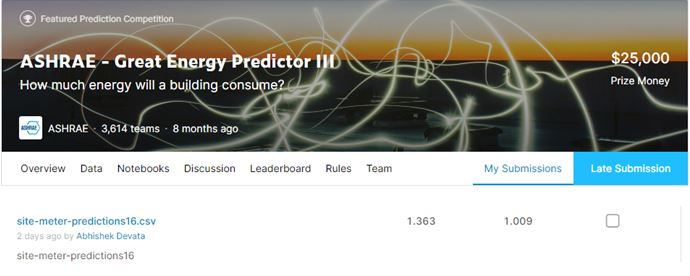

In [1]:
from IPython.display import Image
Image(filename='site_meter.JPG')                                                                                                                                                                                                         